In [82]:

from datasets import load_dataset, DatasetDict
from transformers import ViTForImageClassification, ViTFeatureExtractor, DefaultDataCollator
from transformers import TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

dataset_dir = "/home/clap/Documents/miniproject_bioinformatic/project/dataset_beans"
beans_dataset = load_dataset("imagefolder", data_dir=dataset_dir)

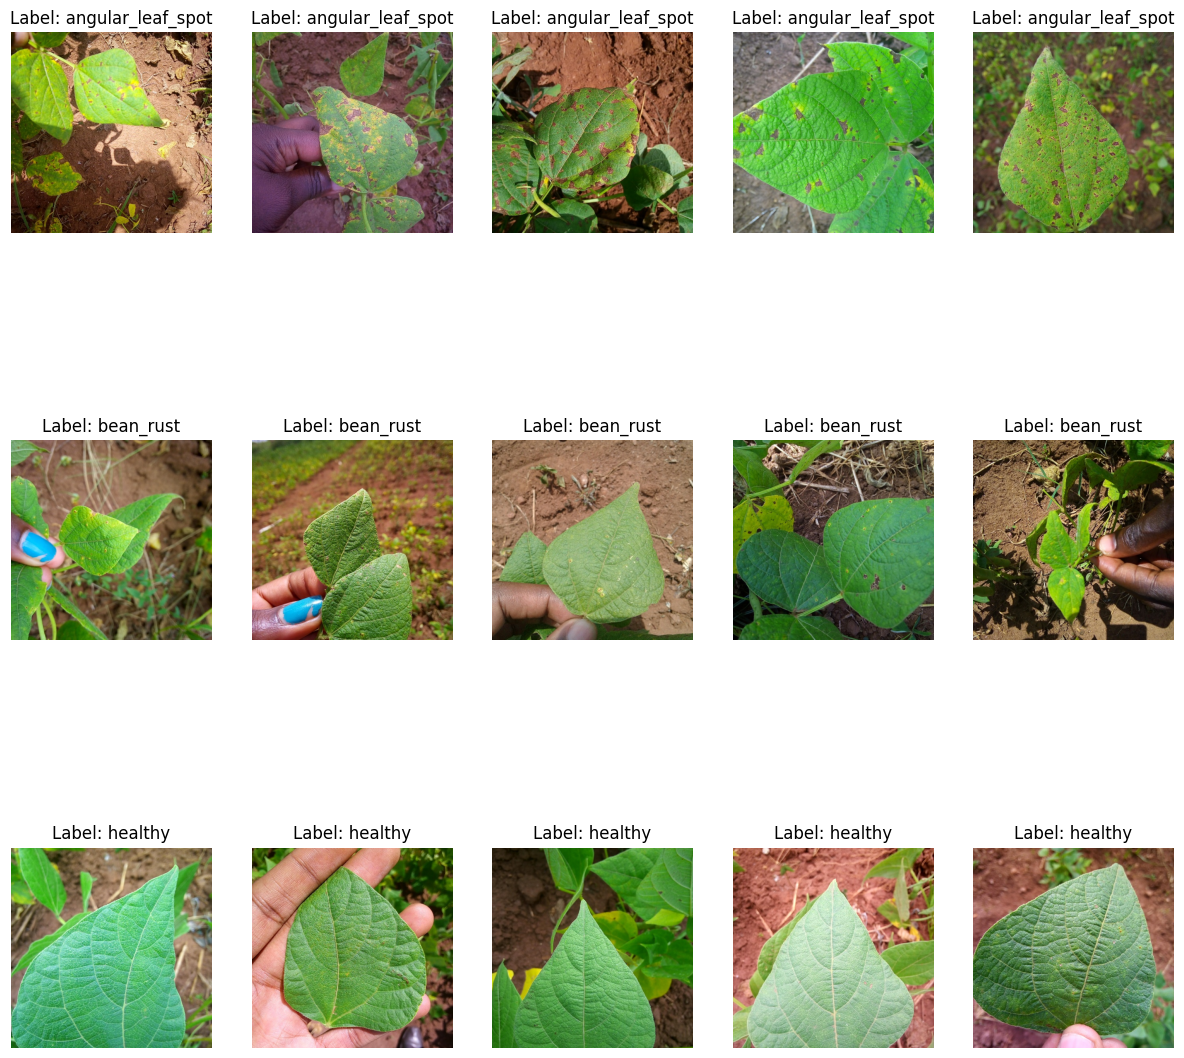

In [90]:
import matplotlib.pyplot as plt
# Function to display images with labels
def show_images_with_labels(dataset, num_images=5):
    ds_features = dataset.features
    fig, axes = plt.subplots(3, num_images, figsize=(15, 15))
    for index_label in range(3):
        label_dataset = dataset.filter(lambda example: example['label'] == index_label)
        for j, example in enumerate(label_dataset.select(range(num_images))):
            image = example['image']
            label = example['label']
            label = ds_features['label'].int2str(label)
            axes[index_label, j].imshow(image)
            axes[index_label, j].set_title(f"Label: {label}")
            axes[index_label, j].axis('off')
    plt.show()

show_images_with_labels(beans_dataset['train'])

In [84]:
# Preprocess data using ViTFeatureExtractor
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")

def preprocess_data(examples):
    # Extract pixel values and normalize images
    images = [image for image in examples["image"]]
    inputs = feature_extractor(images=images, return_tensors="np")
    examples["pixel_values"] = inputs["pixel_values"]
    return examples

# Apply preprocessing to train and test splits
beans_data = beans_dataset.map(preprocess_data, batched=True)

# Remove unused columns and set format for PyTorch
beans_data = beans_data.remove_columns(["image"])
beans_data.set_format("torch", columns=["pixel_values", "label"])



/home/clap/Documents/www/bean-leaf-classification-transformer/.venv/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Map: 100%|██████████| 128/128 [00:00<00:00, 156.53 examples/s]


In [85]:
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=3,  # Beans dataset has 3 classes
    id2label={0: "angular_leaf_spot", 1: "bean_rust", 2: "healthy"},
    label2id={"angular_leaf_spot": 0, "bean_rust": 1, "healthy": 2},
     ignore_mismatched_sizes=True  
)
# Define training arguments
training_args = TrainingArguments(
    output_dir="./vit-beans",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir="./logs",
    logging_steps=10,
)


# Data collator for padding
data_collator = DefaultDataCollator()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/clap/Documents/www/bean-leaf-classification-transformer/.venv/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [86]:
# Define metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support, accuracy_score


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=beans_data["train"],
    eval_dataset=beans_data["validation"],
    tokenizer=feature_extractor,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Evaluate on test set
test_results = trainer.evaluate(eval_dataset=beans_data["test"])
print(f"Test Results: {test_results}")

/tmp/ipykernel_118346/64860325.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
  3%|▎         | 10/325 [00:33<16:59,  3.24s/it]

{'loss': 1.0206, 'grad_norm': 5.652177810668945, 'learning_rate': 1.9384615384615386e-05, 'epoch': 0.15}


  6%|▌         | 20/325 [01:06<16:36,  3.27s/it]

{'loss': 0.5903, 'grad_norm': 3.931535482406616, 'learning_rate': 1.876923076923077e-05, 'epoch': 0.31}


  9%|▉         | 30/325 [01:39<16:28,  3.35s/it]

{'loss': 0.4558, 'grad_norm': 3.1174449920654297, 'learning_rate': 1.8153846153846155e-05, 'epoch': 0.46}


 12%|█▏        | 40/325 [02:14<16:36,  3.50s/it]

{'loss': 0.298, 'grad_norm': 2.59321928024292, 'learning_rate': 1.753846153846154e-05, 'epoch': 0.62}


 15%|█▌        | 50/325 [02:50<16:29,  3.60s/it]

{'loss': 0.1776, 'grad_norm': 2.3760619163513184, 'learning_rate': 1.6923076923076924e-05, 'epoch': 0.77}


 18%|█▊        | 60/325 [03:27<16:17,  3.69s/it]

{'loss': 0.1712, 'grad_norm': 3.0133707523345947, 'learning_rate': 1.630769230769231e-05, 'epoch': 0.92}


 20%|██        | 65/325 [03:54<14:17,  3.30s/it]

{'eval_loss': 0.07236558198928833, 'eval_accuracy': 0.9699248120300752, 'eval_precision': 0.9723799294153752, 'eval_recall': 0.9699248120300752, 'eval_f1': 0.9698486337424107, 'eval_runtime': 10.4442, 'eval_samples_per_second': 12.734, 'eval_steps_per_second': 0.862, 'epoch': 1.0}


 22%|██▏       | 70/325 [04:14<19:09,  4.51s/it]

{'loss': 0.1328, 'grad_norm': 2.630774736404419, 'learning_rate': 1.5692307692307693e-05, 'epoch': 1.08}


 25%|██▍       | 80/325 [04:51<15:25,  3.78s/it]

{'loss': 0.1004, 'grad_norm': 0.7989423274993896, 'learning_rate': 1.5076923076923078e-05, 'epoch': 1.23}


 28%|██▊       | 90/325 [05:29<14:38,  3.74s/it]

{'loss': 0.0757, 'grad_norm': 1.89228093624115, 'learning_rate': 1.4461538461538462e-05, 'epoch': 1.38}


 31%|███       | 100/325 [06:06<14:06,  3.76s/it]

{'loss': 0.0461, 'grad_norm': 2.95994234085083, 'learning_rate': 1.3846153846153847e-05, 'epoch': 1.54}


 34%|███▍      | 110/325 [06:43<13:17,  3.71s/it]

{'loss': 0.0348, 'grad_norm': 1.5841485261917114, 'learning_rate': 1.3230769230769231e-05, 'epoch': 1.69}


 37%|███▋      | 120/325 [07:21<12:52,  3.77s/it]

{'loss': 0.0604, 'grad_norm': 0.18027283251285553, 'learning_rate': 1.2615384615384616e-05, 'epoch': 1.85}


 40%|████      | 130/325 [07:57<10:45,  3.31s/it]

{'loss': 0.0379, 'grad_norm': 0.36292827129364014, 'learning_rate': 1.2e-05, 'epoch': 2.0}



 40%|████      | 130/325 [08:08<10:45,  3.31s/it]

{'eval_loss': 0.02306262217462063, 'eval_accuracy': 0.9924812030075187, 'eval_precision': 0.9926446551160509, 'eval_recall': 0.9924812030075187, 'eval_f1': 0.9924793036019379, 'eval_runtime': 10.7028, 'eval_samples_per_second': 12.427, 'eval_steps_per_second': 0.841, 'epoch': 2.0}


 43%|████▎     | 140/325 [08:46<12:05,  3.92s/it]

{'loss': 0.0143, 'grad_norm': 0.1665523499250412, 'learning_rate': 1.1384615384615385e-05, 'epoch': 2.15}


 46%|████▌     | 150/325 [09:24<11:04,  3.80s/it]

{'loss': 0.0075, 'grad_norm': 0.34550440311431885, 'learning_rate': 1.076923076923077e-05, 'epoch': 2.31}


 49%|████▉     | 160/325 [10:02<10:20,  3.76s/it]

{'loss': 0.0065, 'grad_norm': 0.08542060106992722, 'learning_rate': 1.0153846153846154e-05, 'epoch': 2.46}


 52%|█████▏    | 170/325 [10:40<09:39,  3.74s/it]

{'loss': 0.0065, 'grad_norm': 0.244626984000206, 'learning_rate': 9.53846153846154e-06, 'epoch': 2.62}


 55%|█████▌    | 180/325 [11:18<09:08,  3.78s/it]

{'loss': 0.0264, 'grad_norm': 0.8105876445770264, 'learning_rate': 8.923076923076925e-06, 'epoch': 2.77}


 58%|█████▊    | 190/325 [11:55<08:31,  3.79s/it]

{'loss': 0.007, 'grad_norm': 1.4227129220962524, 'learning_rate': 8.307692307692309e-06, 'epoch': 2.92}


 60%|██████    | 195/325 [12:24<07:20,  3.39s/it]

{'eval_loss': 0.03083922155201435, 'eval_accuracy': 0.9924812030075187, 'eval_precision': 0.9926446551160509, 'eval_recall': 0.9924812030075187, 'eval_f1': 0.9924793036019379, 'eval_runtime': 10.7545, 'eval_samples_per_second': 12.367, 'eval_steps_per_second': 0.837, 'epoch': 3.0}


 62%|██████▏   | 200/325 [12:43<09:26,  4.54s/it]

{'loss': 0.0057, 'grad_norm': 0.04279690980911255, 'learning_rate': 7.692307692307694e-06, 'epoch': 3.08}


 65%|██████▍   | 210/325 [13:21<07:16,  3.79s/it]

{'loss': 0.004, 'grad_norm': 0.07637479901313782, 'learning_rate': 7.076923076923078e-06, 'epoch': 3.23}


 68%|██████▊   | 220/325 [13:59<06:34,  3.76s/it]

{'loss': 0.0041, 'grad_norm': 0.06596220284700394, 'learning_rate': 6.461538461538463e-06, 'epoch': 3.38}


 71%|███████   | 230/325 [14:37<05:58,  3.77s/it]

{'loss': 0.0035, 'grad_norm': 0.09062594175338745, 'learning_rate': 5.846153846153847e-06, 'epoch': 3.54}


 74%|███████▍  | 240/325 [15:14<05:21,  3.79s/it]

{'loss': 0.003, 'grad_norm': 0.11189155280590057, 'learning_rate': 5.230769230769232e-06, 'epoch': 3.69}


 77%|███████▋  | 250/325 [15:52<04:45,  3.81s/it]

{'loss': 0.0032, 'grad_norm': 0.16321265697479248, 'learning_rate': 4.615384615384616e-06, 'epoch': 3.85}


 80%|████████  | 260/325 [16:29<03:37,  3.35s/it]

{'loss': 0.0036, 'grad_norm': 0.046138714998960495, 'learning_rate': 4.000000000000001e-06, 'epoch': 4.0}



 80%|████████  | 260/325 [16:40<03:37,  3.35s/it]

{'eval_loss': 0.01626214012503624, 'eval_accuracy': 0.9924812030075187, 'eval_precision': 0.9926446551160509, 'eval_recall': 0.9924812030075187, 'eval_f1': 0.9924793036019379, 'eval_runtime': 10.629, 'eval_samples_per_second': 12.513, 'eval_steps_per_second': 0.847, 'epoch': 4.0}


 83%|████████▎ | 270/325 [17:18<03:35,  3.92s/it]

{'loss': 0.0022, 'grad_norm': 0.040231164544820786, 'learning_rate': 3.384615384615385e-06, 'epoch': 4.15}


 86%|████████▌ | 280/325 [17:56<02:50,  3.78s/it]

{'loss': 0.0028, 'grad_norm': 0.08843178302049637, 'learning_rate': 2.7692307692307697e-06, 'epoch': 4.31}


 89%|████████▉ | 290/325 [18:34<02:11,  3.77s/it]

{'loss': 0.0025, 'grad_norm': 0.07494867593050003, 'learning_rate': 2.153846153846154e-06, 'epoch': 4.46}


 92%|█████████▏| 300/325 [19:12<01:35,  3.82s/it]

{'loss': 0.0026, 'grad_norm': 0.03128863498568535, 'learning_rate': 1.5384615384615387e-06, 'epoch': 4.62}


 95%|█████████▌| 310/325 [19:50<00:56,  3.75s/it]

{'loss': 0.0027, 'grad_norm': 0.05184698849916458, 'learning_rate': 9.230769230769232e-07, 'epoch': 4.77}


 98%|█████████▊| 320/325 [20:28<00:19,  3.90s/it]

{'loss': 0.0021, 'grad_norm': 0.03874220699071884, 'learning_rate': 3.0769230769230774e-07, 'epoch': 4.92}


100%|██████████| 325/325 [20:56<00:00,  3.34s/it]

{'eval_loss': 0.016412215307354927, 'eval_accuracy': 0.9924812030075187, 'eval_precision': 0.9926446551160509, 'eval_recall': 0.9924812030075187, 'eval_f1': 0.9924793036019379, 'eval_runtime': 10.5765, 'eval_samples_per_second': 12.575, 'eval_steps_per_second': 0.851, 'epoch': 5.0}


100%|██████████| 325/325 [20:57<00:00,  3.87s/it]


{'train_runtime': 1257.7818, 'train_samples_per_second': 4.11, 'train_steps_per_second': 0.258, 'train_loss': 0.10193623148477994, 'epoch': 5.0}


100%|██████████| 8/8 [00:08<00:00,  1.12s/it]

Test Results: {'eval_loss': 0.08305366337299347, 'eval_accuracy': 0.9609375, 'eval_precision': 0.9625944459172853, 'eval_recall': 0.9609375, 'eval_f1': 0.9611767696790372, 'eval_runtime': 10.2883, 'eval_samples_per_second': 12.441, 'eval_steps_per_second': 0.778, 'epoch': 5.0}


In [87]:
from sklearn.metrics import precision_recall_fscore_support

# Run predictions on the test set
predictions = trainer.predict(beans_data["test"])

# Get the true labels and predicted labels
true_labels = predictions.label_ids
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

100%|██████████| 8/8 [00:08<00:00,  1.12s/it]

Accuracy: 0.96
Precision: 0.96
Recall: 0.96
F1 Score: 0.96


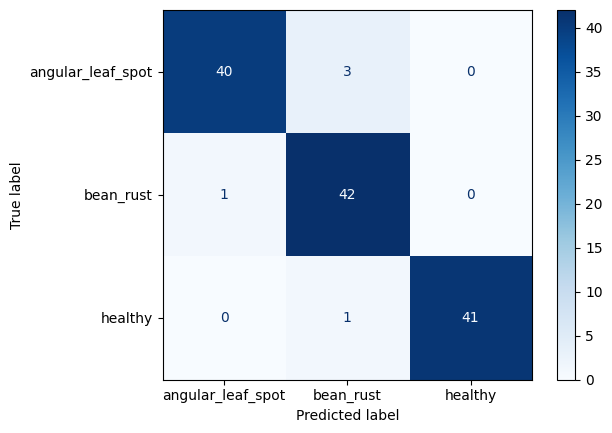

In [88]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt


# Get the true labels and predicted labels
true_labels = predictions.label_ids
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["angular_leaf_spot", "bean_rust", "healthy"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [89]:
print(model)


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe